<a href="https://colab.research.google.com/github/fpsomad/fpsomad/blob/main/Darknet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
# εισαγωγή βιβλιοθηκών.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier


In [83]:
# εισαγωγή συνόλου δεδομένων.
data = pd.read_csv('https://raw.githubusercontent.com/kdemertzis/EKPA/main/Data/DarkNet.csv', low_memory = False)
data.info()





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68580 entries, 0 to 68579
Data columns (total 83 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Src_IP                      68580 non-null  object 
 1   Src_Port                    68580 non-null  int64  
 2   Dst_IP                      68580 non-null  object 
 3   Dst_Port                    68580 non-null  int64  
 4   Protocol                    68580 non-null  int64  
 5   Flow_Duration               68580 non-null  int64  
 6   Total_Fwd_Packet            68580 non-null  int64  
 7   Total_Bwd_packets           68580 non-null  int64  
 8   Total_Length_of_Fwd_Packet  68580 non-null  int64  
 9   Total_Length_of_Bwd_Packet  68580 non-null  int64  
 10  Fwd_Packet_Length_Max       68580 non-null  int64  
 11  Fwd_Packet_Length_Min       68580 non-null  int64  
 12  Fwd_Packet_Length_Mean      68580 non-null  float64
 13  Fwd_Packet_Length_Std       685

In [84]:
# έλεγχος του συνόλου δεδομένων για κενές ή ελλείπουσες τιμές.
data.isnull().sum()


Src_IP      0
Src_Port    0
Dst_IP      0
Dst_Port    0
Protocol    0
           ..
Idle_Std    0
Idle_Max    0
Idle_Min    0
Label-1     0
Label-2     0
Length: 83, dtype: int64

In [85]:
# ενοποίηση ονομάτων υπηρεσιών.
data['Label-2'] = data['Label-2'].replace(['AUDIO-STREAMING', 'Video-streaming', 'File-transfer'], ['Audio-Streaming', 'Video-Streaming','File-Transfer'])
data['Label-2'].unique()
data.groupby(data['Label-2']).size()

Label-2
Audio-Streaming     7539
Browsing            5192
Chat               11478
Email               6145
File-Transfer      11182
P2P                13711
VOIP                3566
Video-Streaming     9767
dtype: int64

In [86]:
# ορισμός κλάσης για ταξινόμηση κίνησης "Class: 0 (normal)  1 (DarkNet)" .
conditions = [
    (data['Label-1'] == 'Non-Tor'),
    (data['Label-1'] == 'NonVPN'),
    (data['Label-1'] == 'Tor'),
    (data['Label-1'] == 'VPN')]
values = [0,0,1,1]
data['Class'] = np.select(conditions, values)
data.groupby(data['Class']).size()



Class
0    53671
1    14909
dtype: int64

([<matplotlib.patches.Wedge at 0x7bcf96b54ee0>,
 [Text(-0.8532727834197007, 0.694208583262406, 'Normal'),
  Text(0.8532728159179485, -0.6942085433178239, 'DarkNet')],
 [Text(-0.4654215182289276, 0.37865922723403955, '78%'),
  Text(0.46542153595524455, -0.3786592054460857, '22%')])

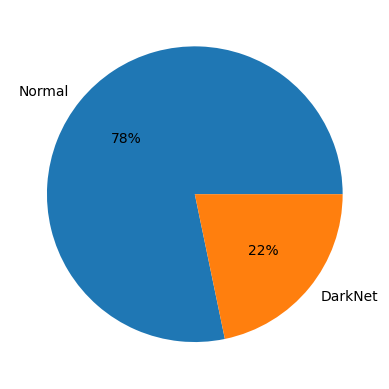

In [87]:
#γραφική απεικόνιση δεδομένων με βάση το άν η κίνηση είναι κανονική ή προέρχεται από το σκοτεινό διαδίκτυο.

type_classify=['Normal', 'DarkNet']
count_classify=[53671,14909]
plt.pie(count_classify, labels=type_classify, autopct='%0.f%%')


In [88]:
# αφαίρεση μη αριθμητικών μεταβλητών.
data = data.drop(['Src_IP','Src_Port', 'Dst_IP','Dst_Port','Protocol', 'Flow_Bytes/s', 'Label-1', 'Label-2'], axis = 1)
data.head()

,Flow_Duration,Total_Fwd_Packet,Total_Bwd_packets,Total_Length_of_Fwd_Packet,Total_Length_of_Bwd_Packet,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,Fwd_Packet_Length_Std,Bwd_Packet_Length_Max,...,Fwd_Seg_Size_Min,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Class
0,229,1,1,0,0,0,0,0.000000,0.000000,0,...,20,0,0,0,0,0,0.000,0,0,0
1,407,1,1,0,0,0,0,0.000000,0.000000,0,...,20,0,0,0,0,0,0.000,0,0,0
2,431,1,1,0,0,0,0,0.000000,0.000000,0,...,20,0,0,0,0,0,0.000,0,0,0
3,359,1,1,0,0,0,0,0.000000,0.000000,0,...,20,0,0,0,0,0,0.000,0,0,0
4,10778451,591,400,64530,6659,131,0,109.187817,22.283313,498,...,20,0,0,0,0,1437760000000000,3117718.131,1437760000000000,1437760000000000,0


In [89]:
# αφαίρεση ακροτάτων τιμών από το σύνολο δεδομένων.
data = data[np.isfinite(data).all(1)]


In [90]:
# ανακάτεμα συνόλου δεδομένων.
data = data.sample(frac=1)
data.head()

,Flow_Duration,Total_Fwd_Packet,Total_Bwd_packets,Total_Length_of_Fwd_Packet,Total_Length_of_Bwd_Packet,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,Fwd_Packet_Length_Std,Bwd_Packet_Length_Max,...,Fwd_Seg_Size_Min,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Class
917,5560177,7,0,784,0,112,112,112.000000,0.000000,0,...,8,0,0,0,0,1437760000000000,1.668570e+06,1437760000000000,1437760000000000,0
67423,119998992,6001,5984,498083,496672,83,83,83.000000,0.000000,83,...,8,0,0,0,0,1432310000000000,3.463417e+07,1432310000000000,1432310000000000,1
41392,9376542,3,0,60,0,20,20,20.000000,0.000000,0,...,8,0,0,0,0,1456330000000000,0.000000e+00,1456330000000000,1456330000000000,0
61460,1782671,6,4,196,180,152,0,32.666667,61.052982,104,...,32,0,0,0,0,1429040000000000,7.320653e+05,1429040000000000,1429040000000000,1
35850,118326885,3,3,68,0,68,0,22.666667,39.259818,0,...,20,0,0,0,0,1092240000000000,7.281610e+14,1456320000000000,118296681,0


In [91]:
# ορισμός Χ και Υ.
X = data.drop('Class', axis=1)
y = data['Class']
X.shape, y.shape


((68531, 75), (68531,))

In [92]:
# κλιμάκωση αριθμητικών δεδομένων.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [93]:
# τμηματοποίηση συνόλου δεδομένων 80% για εκπαίδευση, 20% για έλεγχο.
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42)
X_train.shape, X_test.shape, y_train.shape,y_test.shape

((54824, 75), (13707, 75), (54824,), (13707,))

In [101]:
# εφαρμογή αλγορίθμων ταξινόμησης (Classifiers).

# ορισμός αλγορίθμων.
classifiers = [ DecisionTreeClassifier(max_depth = 5), RandomForestClassifier(max_depth = 8), MLPClassifier(alpha=0.001, hidden_layer_sizes=([100,100,100])),
               GradientBoostingClassifier(n_estimators=100, learning_rate=0.5, max_features=2, max_depth=2, random_state=0)]

# αξιολόγηση και σύγκριση αλγορίθμων.
results_train = {'Classifier': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}
results_test = {'Classifier': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}

for clf in classifiers:
    clf_name = clf.__class__.__name__

    # εκπαίδευση αλγορίθμου.
    clf.fit(X_train, y_train)

    # πρόβλεψη αλγορίθμου.
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    # Υπολογισμός μετρικών αξιολόγησης για τα σύνολα δεδομένων εκπαίδευσης και δοκιμής.
    acc_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred, average='weighted')
    recall_train = recall_score(y_train, y_train_pred, average='weighted')
    f1_train = f1_score(y_train, y_train_pred, average='weighted')

    acc_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred, average='weighted')
    recall_test = recall_score(y_test, y_test_pred, average='weighted')
    f1_test = f1_score(y_test, y_test_pred, average='weighted')


    # Confusion matrix.
    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)

    # Εκτύπωση αποτελεσμάτων για τα σύνολα δεδομένων εκπαίδευσης και δοκιμής.
    print(f"\n{clf_name} Metrics for training:")
    print(f"\nAccuracy: {acc_train}")
    print(f"Precision: {precision_train}")
    print(f"Recall: {recall_train}")
    print(f"F1 Score: {f1_train}")
    print("\nConfusion Matrix:")
    print(cm_train)

    print(f"\n{clf_name} Metrics for testing:")
    print(f"\nAccuracy: {acc_test}")
    print(f"Precision: {precision_test}")
    print(f"Recall: {recall_test}")
    print(f"F1 Score: {f1_test}")
    print("\nConfusion Matrix:")
    print(cm_test)

    # Αποθήκευση αποτελεσμάτων για σύγκριση.
    results_train['Classifier'].append(clf_name)
    results_train['Accuracy'].append(acc_train)
    results_train['Precision'].append(precision_train)
    results_train['Recall'].append(recall_train)
    results_train['F1 Score'].append(f1_train)

    results_test['Classifier'].append(clf_name)
    results_test['Accuracy'].append(acc_test)
    results_test['Precision'].append(precision_test)
    results_test['Recall'].append(recall_test)
    results_test['F1 Score'].append(f1_test)


DecisionTreeClassifier Metrics for training:

Accuracy: 0.938475849992704
Precision: 0.9374388380424042
Recall: 0.938475849992704
F1 Score: 0.9371192267275605

Confusion Matrix:
[[41856  1015]
 [ 2358  9595]]

DecisionTreeClassifier Metrics for testing:

Accuracy: 0.9364558254906252
Precision: 0.9353027823558173
Recall: 0.9364558254906252
F1 Score: 0.9349793046484766

Confusion Matrix:
[[10489   262]
 [  609  2347]]

RandomForestClassifier Metrics for training:

Accuracy: 0.9601816722603239
Precision: 0.9604657000335926
Recall: 0.9601816722603239
F1 Score: 0.9591730133403158

Confusion Matrix:
[[42542   329]
 [ 1854 10099]]

RandomForestClassifier Metrics for testing:

Accuracy: 0.9556431020646385
Precision: 0.9556710707569444
Recall: 0.9556431020646385
F1 Score: 0.9544916173698889

Confusion Matrix:
[[10639   112]
 [  496  2460]]


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



MLPClassifier Metrics for training:

Accuracy: 0.952356632131913
Precision: 0.9521614988146636
Recall: 0.952356632131913
F1 Score: 0.9522492833733578

Confusion Matrix:
[[41639  1232]
 [ 1380 10573]]

MLPClassifier Metrics for testing:

Accuracy: 0.9407601955205369
Precision: 0.9403800220605616
Recall: 0.9407601955205369
F1 Score: 0.9405464112575727

Confusion Matrix:
[[10374   377]
 [  435  2521]]

GradientBoostingClassifier Metrics for training:

Accuracy: 0.9513534218590398
Precision: 0.9508307845186129
Recall: 0.9513534218590398
F1 Score: 0.9503908754796049

Confusion Matrix:
[[42145   726]
 [ 1941 10012]]

GradientBoostingClassifier Metrics for testing:

Accuracy: 0.9471802728532867
Precision: 0.946426567584258
Recall: 0.9471802728532867
F1 Score: 0.9461769084768571

Confusion Matrix:
[[10533   218]
 [  506  2450]]


In [102]:
# Απεικόνιση μετρικών απόδοσης των αλγορίθμων.
results_df_train = pd.DataFrame(results_train)
results_df_train = results_df_train.sort_values(by='Accuracy', ascending=False)
print("\nComparison of Classifiers for training:")
print(results_df_train)

results_df_test = pd.DataFrame(results_test)
results_df_test = results_df_test.sort_values(by='Accuracy', ascending=False)
print("\nComparison of Classifiers for testing:")
print(results_df_test)



Comparison of Classifiers for training:
                   Classifier  Accuracy  Precision    Recall  F1 Score
1      RandomForestClassifier  0.960182   0.960466  0.960182  0.959173
2               MLPClassifier  0.952357   0.952161  0.952357  0.952249
3  GradientBoostingClassifier  0.951353   0.950831  0.951353  0.950391
0      DecisionTreeClassifier  0.938476   0.937439  0.938476  0.937119

Comparison of Classifiers for testing:
                   Classifier  Accuracy  Precision    Recall  F1 Score
1      RandomForestClassifier  0.955643   0.955671  0.955643  0.954492
3  GradientBoostingClassifier  0.947180   0.946427  0.947180  0.946177
2               MLPClassifier  0.940760   0.940380  0.940760  0.940546
0      DecisionTreeClassifier  0.936456   0.935303  0.936456  0.934979
